<a href="https://colab.research.google.com/github/trevorwjames/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Trevor_James_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# adding in a val during the data set loading
train, val = train_test_split(train, train_size=.80, test_size=.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [52]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

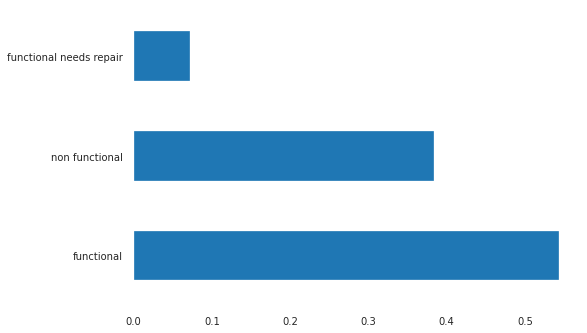

In [54]:
train['status_group'].value_counts(normalize=True).plot(kind='barh')

In [55]:
#Baseline for our predictions - 54.3% accuracy in predicting the correct value

train['status_group'].value_counts(normalize=True)


functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 43360 to 49783
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47520 non-null  int64  
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44616 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44603 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47234 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15

In [57]:
import numpy as np

In [58]:
def wrangle(X):

  # Working with a copy
  X = X.copy()

  # dealing with very small near 0 values 
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # replacing the missing values that are actually 0 with NaNs
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # dropping repetive column, as well as id column
  X = X.drop(columns=['quantity_group', 'id'])

  # convert date_recorded feature to date_time
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])

  return X

In [59]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [61]:
# Validating wrangle function kept #s I wanted
print(train.shape)
print(val.shape)
print(test.shape)

(47520, 39)
(11880, 39)
(14358, 38)


In [64]:
# data cleaning of high cardinality features
target = 'status_group'

train_features = train.drop(columns=target)

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <=50].index.tolist()

features = numeric_features + categorical_features

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [ ]:
def features(X, y):
  y = 'status_group'

  X

In [65]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [66]:
# importing libraries
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [67]:
# build model using Kbest feature of 30
model1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=30),
    DecisionTreeClassifier(random_state=42)
)

In [ ]:
# see model doc
model1

In [69]:
#fit model to training data
model1fit = model1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [42] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [70]:
# accuracty of train data
model1fit.score(X_train, y_train)

0.8726010101010101

In [71]:
# accuracty of val data
model1fit.score(X_val, y_val)

0.7083333333333334

Looks like with the descrepancy btw the two values the model is overfit to the train data


In [75]:
# new model working with depth param
model_depth5 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=30),
    DecisionTreeClassifier(random_state=42, max_depth=5)
)

In [ ]:
model_depth5.fit(X_train, y_train);

In [77]:
model_depth5.score(X_train, y_train)

0.7091540404040404

In [85]:
# increasing depth to 15
model_depth15 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=30),
    DecisionTreeClassifier(random_state=42, max_depth=15)
);

#fitting model
model_depth15.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_depth15.score(X_train, y_train))
print('Val data accuracy:', model_depth15.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [42] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Data Accuracy: 0.7778409090909091


In [88]:
# increaseing model depth again to 30
model_depth30 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=30),
    DecisionTreeClassifier(random_state=42, max_depth=30)
);

#fitting model
model_depth30.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_depth30.score(X_train, y_train))
print('Val data accuracy:', model_depth30.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [42] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Data Accuracy: 0.8670664983164983
Val data accuracy: 0.7098484848484848


Looks like increasing the depth to 30 created to much fit to the training data that we had at first 

In [93]:
# looks like ill work with 12 for now
model_depth12 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=30),
    DecisionTreeClassifier(random_state=42, max_depth=12)
);

#fitting model
model_depth12.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_depth12.score(X_train, y_train))
print('Val data accuracy:', model_depth12.score(X_val, y_val))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [42] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Data Accuracy: 0.7540614478114478
Val data accuracy: 0.7314814814814815


In [94]:
# increasing kbest to 40 

model_depth12_k40 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(), 
    SelectKBest(k=40),
    DecisionTreeClassifier(random_state=42, max_depth=12)
);

#fitting model
model_depth12_k40.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_depth12_k40.score(X_train, y_train))
print('Val data accuracy:', model_depth12_k40.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [42] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Data Accuracy: 0.7629208754208754
Val data accuracy: 0.7390572390572391


In [99]:

model_depth12_nok = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, max_depth=12)
);

#fitting model
model_depth12_nok.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_depth12_nok.score(X_train, y_train))
print('Val data accuracy:', model_depth12_nok.score(X_val, y_val))

Training Data Accuracy: 0.7869107744107744
Val data accuracy: 0.7553030303030303


guess kbest wasnt doing so hot, Works better without


In [104]:

model_nok = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, max_depth=18)
);

#fitting model
model_nok.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_nok.score(X_train, y_train))
print('Val data accuracy:', model_nok.score(X_val, y_val))

Training Data Accuracy: 0.8790614478114478
Val data accuracy: 0.774074074074074


In [118]:
y_pred = model_nok.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('trevor-james-submission.csv', index=False)

Feature Importance Graph

In [110]:
model = model_nok.named_steps['decisiontreeclassifier']

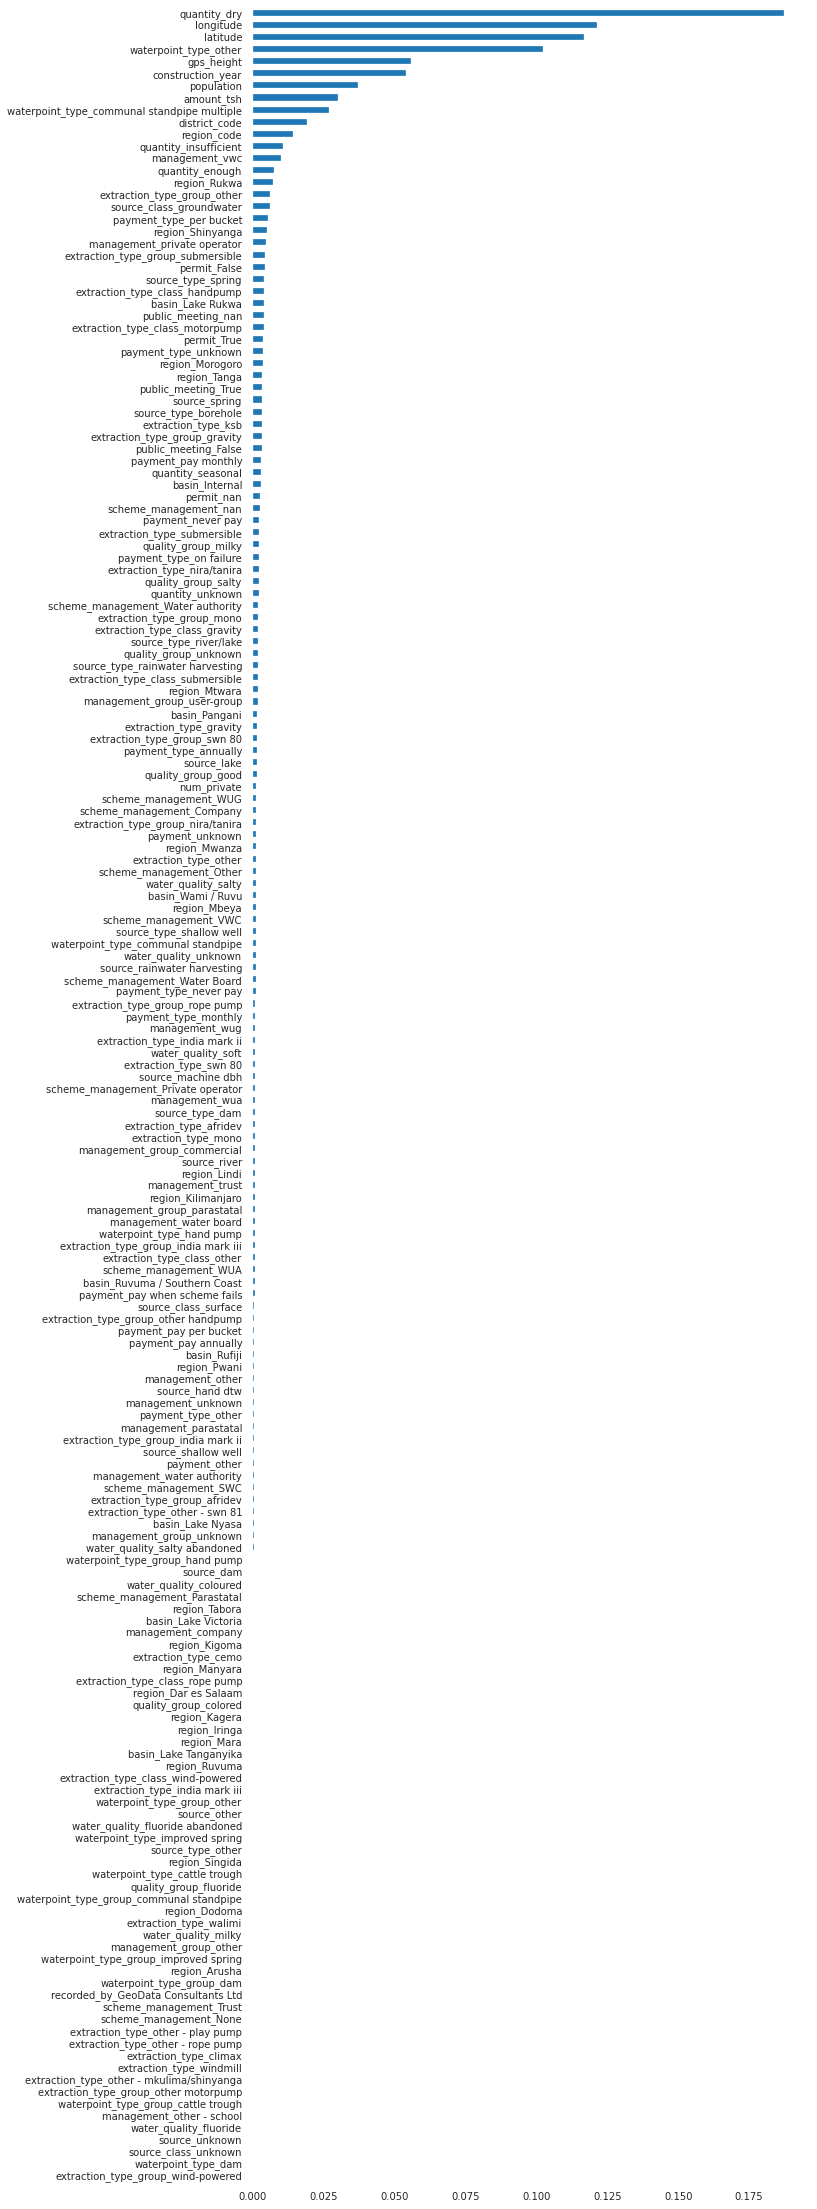

In [114]:
import matplotlib.pyplot as plt


encoder = model_nok.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,40))
importances.sort_values().plot.barh()

Stretch goal: trying a new imputer

In [123]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [124]:
# using an nearest neighbors imputer
model_stretch1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    KNNImputer(n_neighbors=2, weights="uniform"),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, max_depth=18)
);

#fitting model
model_stretch1.fit(X_train, y_train)

#train data score
print('Training Data Accuracy:', model_stretch1.score(X_train, y_train))
print('Val data accuracy:', model_stretch1.score(X_val, y_val))

Training Data Accuracy: 0.8788089225589225
Val data accuracy: 0.773063973063973


Nearest Neighbors imputer did not work as well as Simple Imputer. Just slightly less on both the training and validation data. 


I also tried to run iterative imputer, although after five minutes of running I decided go go with nearest neighbors to see if that would run in a reasonable amount of time. 
